# Level 1 investigation
Name: Soichiro Tanabe

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import csv
import os
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets, metrics, Sequential, utils
from tensorflow.keras.layers import *
from IPython.display import HTML, display
import matplotlib.pyplot as plt
%matplotlib inline

# Data format and structure

The dataset contains just over 50,000 images, each showing a 60m × 60m region of a forest in Germany. Each image shows mainly one species of tree. There are three levels of label for each image: the English name (level 3), forest management class (level 2), and leaf type (level 1).

![Treesat label levels](treesat_label_levels.png)
> Image detail from Ahlswede _et al._ (2023) figure 4.

The dataset has been split into 70% training, 10% validation, and 20% testing images.

The images are 304 × 304 pixels and encoded as four-channel PNG images. We are mis-using the PNG's alpha (transparency) channel to represent the near-IR light band in the original images.

The data resides in the `/datasets/treesat/` directory. All the images are in the `/datasets/treesat/images/` directory. There are three `.csv` files that specify which images are in which split of the dataset. There are three text files that list the different labels at each level.

In [2]:
!ls /datasets/treesat

images			level_3_vocabulary.txt	validation_file_labels.csv
level_1_vocabulary.txt	test_file_labels.csv
level_2_vocabulary.txt	train_file_labels.csv


If we look at one of the `.csv` files, we can see the image name and labels at each level.

In [3]:
!head /datasets/treesat/train_file_labels.csv

Similarly, we can see the distinct labels at each level.

In [4]:
!cat /datasets/treesat/level_2_vocabulary.txt

larch
cleared
beech
oak
douglas fir
pine
fir
short-lived deciduous
long-lived deciduous
spruce


# Defining constants

`label_level` is one of 1, 2, or 3, and is the level of labels used in this notebook.

In [5]:
data_dir = '/datasets/treesat'
label_level = 1

In [6]:
IMAGE_RESCALE = (100, 100)
input_shape = (IMAGE_RESCALE[0], IMAGE_RESCALE[1], 4)
batch_size = 64
label_key = f'level_{label_level}'

# Loading data

First, we load the image names and labels into the `file_label` datasets. 

In [7]:
train_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'train_file_labels.csv'), batch_size=batch_size, num_epochs=1)
train_file_labels = train_file_labels.unbatch()

In [8]:
validation_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'validation_file_labels.csv'), batch_size=batch_size, num_epochs=1)
validation_file_labels = validation_file_labels.unbatch()

In [9]:
test_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'test_file_labels.csv'), batch_size=batch_size, num_epochs=1)
test_file_labels = test_file_labels.unbatch()

We load the vocabulary for this level of labels and create a `StringLookup` encoder that will convert each label into a one-hot vector.

In [10]:
encoder_vocab_file = os.path.join(data_dir, f'level_{label_level}_vocabulary.txt')
label_encoder = StringLookup(vocabulary=encoder_vocab_file, num_oov_indices=0, output_mode='one_hot')

num_classes = len(label_encoder.get_vocabulary())

label_lookup = {i: n for i, n in enumerate(label_encoder.get_vocabulary())}
label_lookup

{0: 'cleared', 1: 'needleleaf', 2: 'broadleaf'}

With the labels defined, we know enough to pretty-print a confusion matrix.

In [11]:
def pretty_cm(cm):
    result_table  = '<h3>Confusion matrix</h3>\n'
    result_table += '<table border=1>\n'
    result_table += f'<tr><td>&nbsp;</td><td>&nbsp;</td><th colspan={len(label_lookup)}>Predicted labels</th></tr>\n'
    result_table += '<tr><td>&nbsp;</td><td>&nbsp;</td>'

    for _, cn in sorted(label_lookup.items()):
        result_table += f'<td><strong>{cn}</strong></td>'
    result_table += '</tr>\n'

    result_table += '<tr>\n'
    result_table += f'<th rowspan={len(label_lookup) + 1}>Actual labels</th>\n'

    for ai, an in sorted(label_lookup.items()):
        result_table += '<tr>\n'
        result_table += f'  <td><strong>{an}</strong></td>\n'
        for pi, pn in sorted(label_lookup.items()):
            result_table += f'  <td>{cm[ai, pi]}</td>\n'
        result_table += '</tr>\n'
    result_table += "</table>"
    # print(result_table)
    display(HTML(result_table))

We have a function that take a filename and text label and returns the image and one-hot encoded label.

In [12]:
# Adjusted load_image function to accept file_path and label separately
def load_image(file_path, label):
    # read the image from disk, decode it, resize it, and scale the pixels intensities to the range [0, 1]
    image = tf.io.read_file(file_path)
    image = tf.io.decode_png(image, channels=4)
    image = tf.image.resize(image, IMAGE_RESCALE)
    image /= 255.0
    
    # grab the label and encode it
    encoded_label = label_encoder(label)
    
    # return the image and the one-hot encoded label
    return image, encoded_label

## Loading the images

Now we can load the images into datasets.

In [13]:
train_data = train_file_labels.map(lambda fl: (fl['file_name'], fl[label_key]), 
                                      num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(200)
train_data = train_data.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [14]:
validation_data = validation_file_labels.map(lambda fl: (fl['file_name'], fl[label_key]), 
                                      num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

In [15]:
test_data = test_file_labels.map(lambda fl: (fl['file_name'], fl[label_key]), 
                                      num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

# Exploring the data

We can now explore some elements of the data, such as some sample images and the distribution of classes.

## Distribution of classes

In [16]:
class_counts = train_file_labels.map(lambda fl: label_encoder(fl[label_key]))
class_counts = class_counts.reduce(tf.zeros((num_classes,)),
                             lambda o, l: tf.math.add(o, l))
class_counts

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 2844., 14150., 18272.], dtype=float32)>

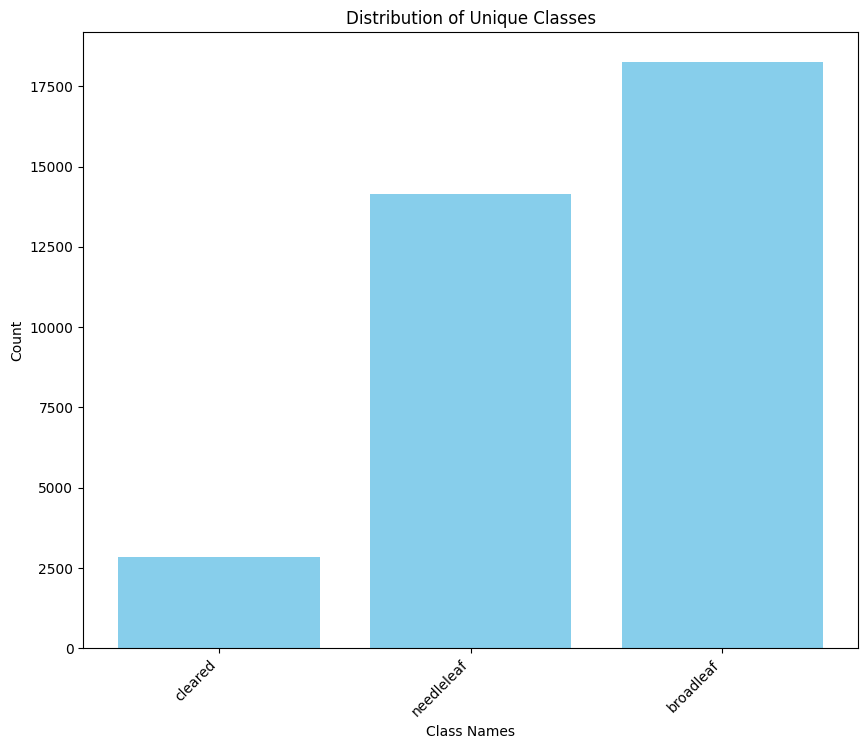

In [17]:
# Plot distribution using class names
plt.figure(figsize=(10, 8))
plt.bar(label_encoder.get_vocabulary(), class_counts.numpy(), color='skyblue')
plt.xlabel("Class Names")
plt.ylabel("Count")
plt.title("Distribution of Unique Classes")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()  # Display the plotted distribution

## Show some sample images

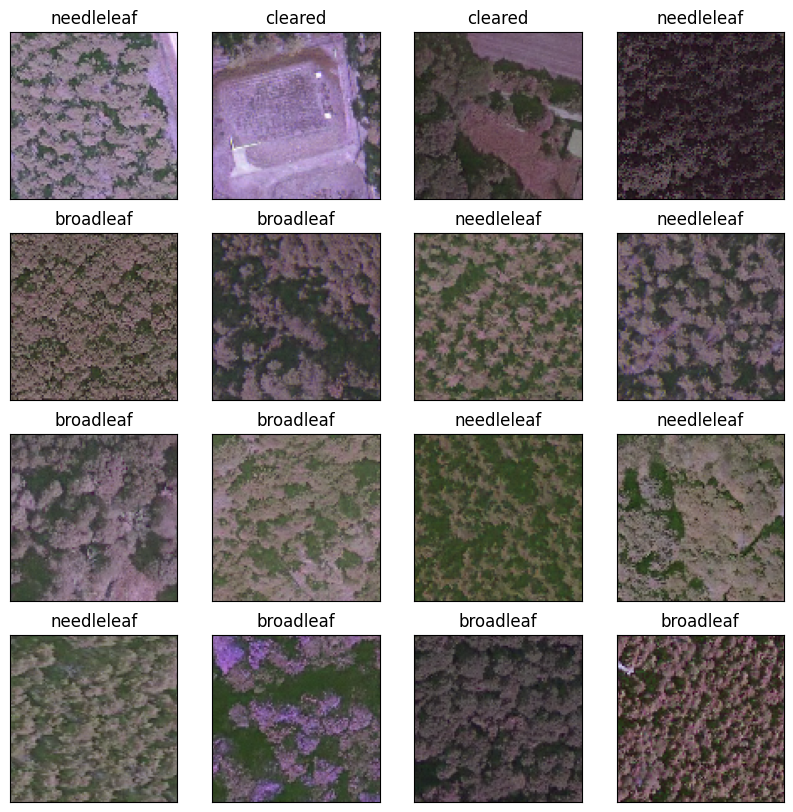

In [18]:
sample_images, sample_labels = train_data.as_numpy_iterator().next()

plt.figure(figsize=(10, 10))
for i in range(16):  # Adjust this number based on how many images you want to display
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i, ..., :-1]) # drop the alpha channel, to make the images more like you'd see
#     plt.imshow(sample_images[i]) # image with alpha channel
    label_index = np.argmax(sample_labels[i])
    class_name = label_lookup[label_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_name)

# Create and train a base model

As the initial model, a simple CNN model was set up, with the following structure:

In [48]:
model_base_level_1 = Sequential([
    Conv2D(8, (5, 5), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(8, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
   
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_base_level_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 100, 100, 8)       808       
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 100, 8)       1608      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 25, 25, 8)         0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 5000)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               640128    
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                      

In [49]:
model_base_level_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
history_base_level_1 = model_base_level_1.fit(
    train_data,
    epochs=20,
    validation_data=validation_data,
    verbose=0
)

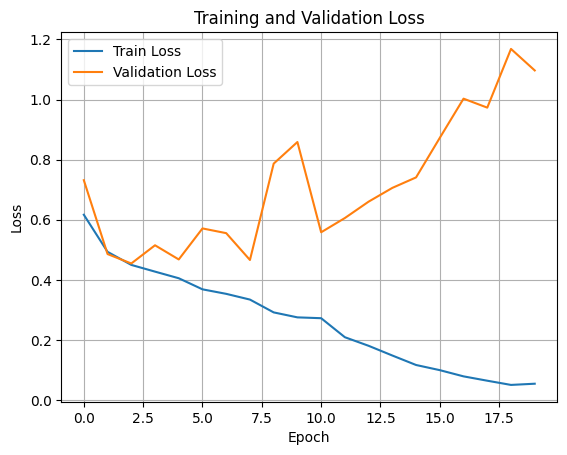

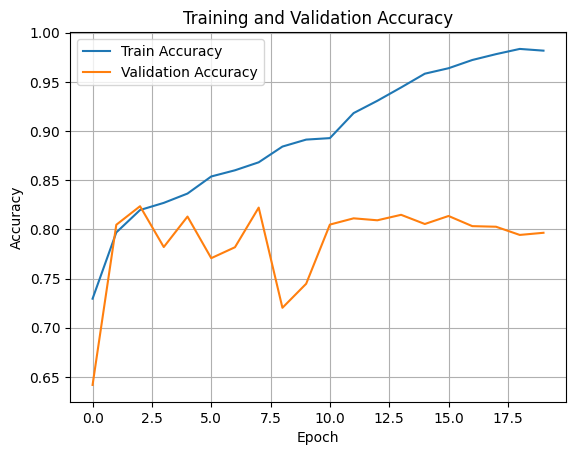

In [51]:
import matplotlib.pyplot as plt

# Assuming history contains the training history returned by model.fit
train_loss = history_base_level_1.history['loss']
val_loss = history_base_level_1.history['val_loss']
train_acc = history_base_level_1.history['accuracy']
val_acc = history_base_level_1.history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Cache results for later

In [52]:
model_base_level_1.save('model_base_level_1.keras')

with open('history_base_level_1.json', 'w') as f:
    json.dump(history_base_level_1.history, f)

In [53]:
model_base_level_1 = tf.keras.models.load_model('model_base_level_1.keras')

with open('history_base_level_1.json') as f:
    history_base_level_1 = json.load(f)

## Evaluating the model

In [54]:
model_base_level_1.evaluate(test_data, return_dict=True)

158/158 [==============================] - 18s 109ms/step - loss: 1.1165 - accuracy: 0.7887


{'loss': 1.1165090799331665, 'accuracy': 0.788726806640625}

In [55]:
test_predictions = model_base_level_1.predict(test_data)

158/158 [==============================] - 14s 90ms/step


In [56]:
predict_labels = np.argmax(test_predictions, axis=1)

In [57]:
test_labels = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels = np.argmax(test_labels, axis=1)

In [58]:
cm = tf.math.confusion_matrix(test_labels, predict_labels).numpy()
pretty_cm(cm)

# Implementing more complicated model

Implementing a more intricate model involves adding additional layers to enable the neural network to capture more intricate patterns within the data, potentially enhancing its predictive capabilities (Saturn Cloud, 2023). Ramesh(2018) states that increasing the number of filters in each layer enhances the depth of the feature space, enabling the CNN to learn more levels of global abstract structures. Additionally, incorporating dropout is beneficial for mitigating overfitting, as demonstrated by the base model, as it encourages the network to learn more robust and generalized representations of the data (The Open University, 2023). Therefore, a more intricate model was structured with additional layers and dropout, as follows:   

In [69]:
# Define the model architecture with additional convolutional layers
model_2_level_1 = Sequential([
    Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(16, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
  
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
  
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(rate=0.5),
    Dense(num_classes, activation='softmax')
])

# Print the summary of the improved model
model_2_level_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 100, 100, 16)      1616      
                                                                 
 conv2d_13 (Conv2D)          (None, 100, 100, 16)      6416      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 25, 25, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 25, 25, 32)        4640      
                                                                 
 conv2d_15 (Conv2D)          (None, 25, 25, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                 

In [70]:
model_2_level_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history_2_level_1 = model_2_level_1.fit(
    train_data,
    epochs=20,
    validation_data=validation_data,
    verbose=0
)


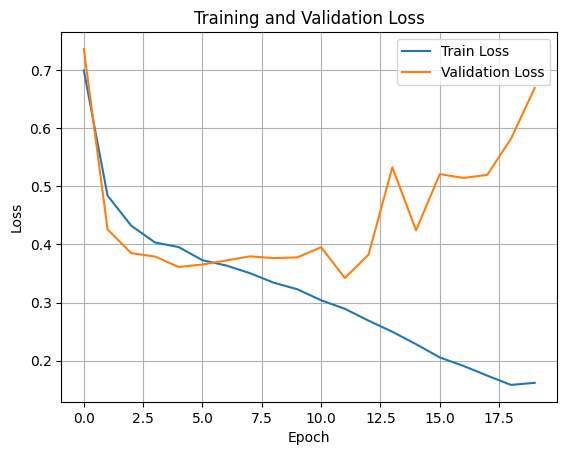

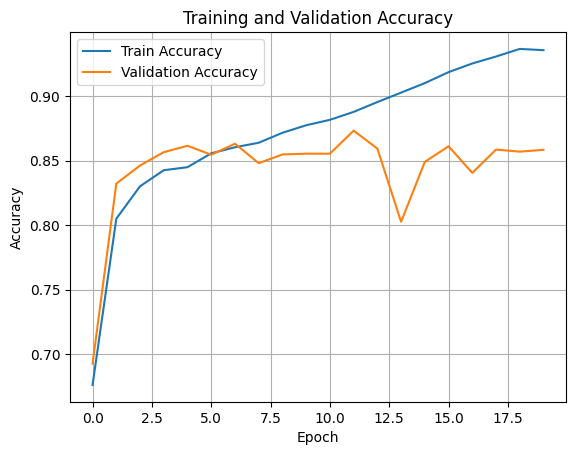

In [71]:
# Assuming history contains the training history returned by model.fit
train_loss_2 = history_2_level_1.history['loss']
val_loss_2 = history_2_level_1.history['val_loss']
train_acc_2 = history_2_level_1.history['accuracy']
val_acc_2 = history_2_level_1.history['val_accuracy']

# Plot loss
plt.plot(train_loss_2, label='Train Loss')
plt.plot(val_loss_2, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(train_acc_2, label='Train Accuracy')
plt.plot(val_acc_2, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Cache results for later

In [72]:
model_2_level_1.save('model_2_level_1.keras')

with open('history_2_level_1.json', 'w') as f:
    json.dump(history_2_level_1.history, f)

model_2_level_1 = tf.keras.models.load_model('model_2_level_1.keras')

with open('history_2_level_1.json') as f:
    history_2_level_1 = json.load(f)

## Evaluating the model

In [73]:
model_2_level_1.evaluate(test_data, return_dict=True)

158/158 [==============================] - 17s 108ms/step - loss: 0.6259 - accuracy: 0.8516


{'loss': 0.6258849501609802, 'accuracy': 0.851642370223999}

In [74]:
test_predictions_2 = model_2_level_1.predict(test_data)

158/158 [==============================] - 14s 90ms/step


In [75]:
predict_labels_2 = np.argmax(test_predictions_2, axis=1)

In [76]:
test_labels_2 = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels_2 = np.argmax(test_labels_2, axis=1)

In [77]:
cm_2 = tf.math.confusion_matrix(test_labels_2, predict_labels_2).numpy()
pretty_cm(cm_2)

# Add weighting

The figure:'Distribution of Unique classes' depicts imbalanced class data, which can profoundly affect classification algorithms, resulting in biased performance (The Open University, 2023). To address this issue, a technique involving weighting imbalanced data was applied to modify the training data. Subsequently, the previous two models, which incorporated increased filters and a more intricate architecture, utilised this modified training data for training.

### Modify training dataset

In [78]:
class_counts = train_data.unbatch().reduce(tf.zeros((3,)),
                             lambda o, il: tf.math.add(o, il[1])).numpy()
class_counts

array([ 2844., 14150., 18272.], dtype=float32)

In [79]:
all_train_size = sum(class_counts)
all_train_size

35266.0

In [21]:
class_weights = tf.constant([all_train_size / (10 * cc) for cc in class_counts])
class_weights

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([1.24001406, 0.24922968, 0.19300569])>

In [22]:
class_weights[0], class_weights[2]

(<tf.Tensor: shape=(), dtype=float64, numpy=1.240014064697609>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.19300569176882662>)

In [23]:
def add_weight(image, one_hot_label):
    label = tf.argmax(one_hot_label)
    return image, one_hot_label, class_weights[label]

In [24]:
weighted_train_data = train_data.unbatch().map(add_weight)
weighted_train_data

<_MapDataset element_spec=(TensorSpec(shape=(100, 100, 4), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [25]:
weighted_train_data = weighted_train_data.batch(batch_size)
weighted_train_data = weighted_train_data.shuffle(all_train_size)
weighted_train_data = weighted_train_data.prefetch(tf.data.AUTOTUNE)

### the Model with Added weights

In [37]:
# Define the model architecture with additional convolutional layers
model_3_level_1 = Sequential = Sequential([
    Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=input_shape),
    Conv2D(16, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(4, 4)),
   
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
  
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(rate=0.5),
    Dense(num_classes, activation='softmax')
])

# Print the summary of the improved model
model_3_level_1 = Sequential.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      1616      
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 16)      6416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                 

In [38]:
model_3_level_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:

history_3_level_1 = model_3_level_1.fit(
    weighted_train_data,
    epochs=20,
    validation_data=validation_data,
    verbose=0
)

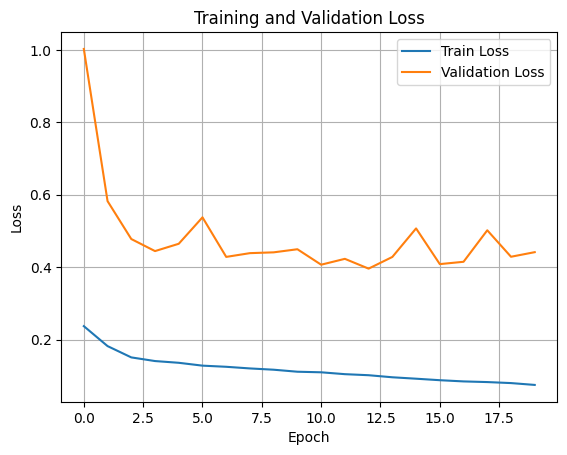

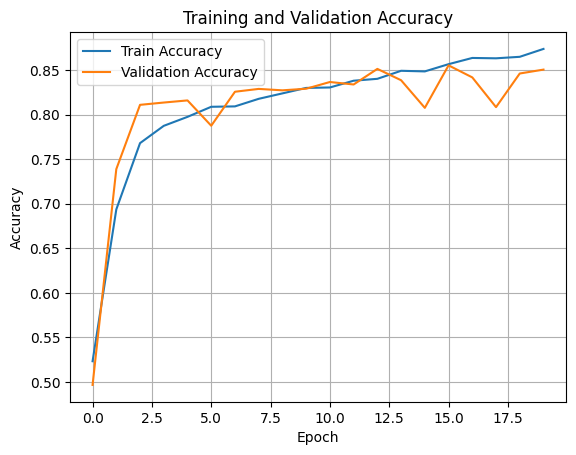

In [40]:
# Assuming history contains the training history returned by model.fit
train_loss_3 = history_3_level_1.history['loss']
val_loss_3 = history_3_level_1.history['val_loss']
train_acc_3 = history_3_level_1.history['accuracy']
val_acc_3 = history_3_level_1.history['val_accuracy']

# Plot loss
plt.plot(train_loss_3, label='Train Loss')
plt.plot(val_loss_3, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(train_acc_3, label='Train Accuracy')
plt.plot(val_acc_3, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Cache results for later

In [41]:
model_3_level_1.save('model_3_level_1.keras')

with open('history_3_level_1.json', 'w') as f:
    json.dump(history_3_level_1.history, f)

In [42]:
model_3_level_1 = tf.keras.models.load_model('model_3_level_1.keras')

with open('history_3_level_1.json') as f:
    history_3_level_1 = json.load(f)

## Evaluating the model

In [43]:
model_3_level_1.evaluate(test_data, return_dict=True)

158/158 [==============================] - 18s 109ms/step - loss: 0.4415 - accuracy: 0.8476


{'loss': 0.44151535630226135, 'accuracy': 0.8475736975669861}

In [44]:
test_predictions_3 = model_3_level_1.predict(test_data)

158/158 [==============================] - 14s 88ms/step


In [45]:
predict_labels_3 = np.argmax(test_predictions_3, axis=1)

In [46]:
test_labels_3 = np.array(list(test_data.unbatch().map(lambda x, y: y).as_numpy_iterator()))
test_labels_3 = np.argmax(test_labels_3, axis=1)

In [47]:
cm_3 = tf.math.confusion_matrix(test_labels_3, predict_labels_3).numpy()
pretty_cm(cm_3)

# Reference

Ramesh. S (2018) ' A guide to an efficient way to build neural network architectures- Part II: Hyper-parameter selection and tuning for Convolutional Neural Networks using Hyperas on Fashion-MNIST', Medium, 7 May 2018 [Online]. Available at https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7 (Accessed 11 May 2024).

Saturn Cloud (2023) How to Improve Accuracy in Neural Networks with Keras, 6 July 2023 [Online] Available at https://saturncloud.io/blog/how-to-improve-accuracy-in-neural-networks-with-keras/ (Accessed 11 May 2024).

The Open University (2023) 5 Training of CNNs, TM358 Weeks 8-11 Block 2: Image recognition with CNNs [Online]. Available at https://learn2.open.ac.uk/mod/oucontent/view.php?id=2152484&section=5.1 (Accessed 11 May 2024).
